In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable

import numpy as np
import itertools
import matplotlib.pyplot as plt

import networks as net
import dataloader as dl
import utils

In [0]:
# シード値の固定
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [0]:
# ハイパーパラメータの定義
lr = 0.0001
betas = (0.5, 0.999)
batch_size = 64
input_size = 128  # patch_size = 8(128/2^4)
num_epochs = 30
lambda_cycle = 10.0
lambda_identity = 5.0

In [5]:
# GPUが使用できるか確認
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('使用デバイス：', device)

使用デバイス： cuda:0


In [6]:
# 各生成器と判別器をインスタンス化
G_A2B = net.Generator()
G_B2A = net.Generator()
D_A = net.Discriminator()
D_B = net.Discriminator()

# GPUが使用できるならモデルをGPUに載せて初期化
if device == 'cuda:0':
    G_A2B.cuda()
    G_B2A.cuda()
    D_A.cuda()
    D_B.cuda()

print('ネットワークの初期化中...', end='')
G_A2B.apply(utils.weights_init)
G_B2A.apply(utils.weights_init)
D_A.apply(utils.weights_init)
D_B.apply(utils.weights_init)
print('完了！')

ネットワークの初期化中...完了！


In [0]:
# 損失関数を定義
criterion_adversarial = nn.MSELoss()  # 敵対的損失，Mean Squared Error
criterion_cycle = nn.L1Loss()         # サイクル一貫性損失，Mean Absorute Error
criterion_identity = nn.L1Loss()      # 同一性損失

In [0]:
# 最適化手法の設定，Generatorは二つのモデルのパラメータを同時に更新
optimizer_G = optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()),
                         lr=lr, betas=betas)
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=betas)
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=betas)

In [0]:
# 識別器への画像提供(過去の履歴画像:50%，最新の生成画像:50%)のヘルパクラス
fake_A_buffer = utils.PreviousBuffer()
fake_B_buffer = utils.PreviousBuffer()

In [0]:
# 真偽判定に用いるテンソルを定義(パッチ形式)
Tensor = torch.cuda.FloatTensor if device == 'cuda:0' else torch.Tensor
target_real = Variable(Tensor(batch_size, 1, 8, 8).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batch_size, 1, 8, 8).fill_(0.0), requires_grad=False)

In [0]:
# データセットのパスを取得
train_img_A, train_img_B = dl.make_datapath_list(is_train=True)

# Datasetを作成
mean = (0.5,)
std = (0.5,)
train_dataset = dl.UnpairedDataset(train_img_A, train_img_B,
                                   transform=dl.ImageTransform(mean, std))

# DataLoaderを作成
train_dataloader = data.DataLoader(train_dataset,
                                   batch_size=batch_size,
                                   shuffle=True)

In [0]:
# ログ保存用
loss_dict = dict()
keys = ['loss_G', 'loss_D', 'loss_G_identity', 'loss_G_adversarial', 'loss_G_cycle']
for k in keys:
    loss_dict[k] = list()

In [13]:
# 訓練
for epoch in range(num_epochs):
    print('batch training', end='')
    for i, batch in enumerate(train_dataloader):
        real_A = batch['A']
        real_B = batch['B']

        # バッチの最後が端数の場合の処理，画像のバッチ数がハイパーパラメータと異なっていたらtargetのサイズを変える/戻す
        if real_A.shape[0] != batch_size:
            target_real = Variable(Tensor(real_A.shape[0], 1, 8, 8).fill_(1.0), requires_grad=False)
            target_fake = Variable(Tensor(real_A.shape[0], 1, 8, 8).fill_(0.0), requires_grad=False)
        else:
            target_real = Variable(Tensor(batch_size, 1, 8, 8).fill_(1.0), requires_grad=False)
            target_fake = Variable(Tensor(batch_size, 1, 8, 8).fill_(0.0), requires_grad=False)

        ########## Generatorの訓練 ##########
        optimizer_G.zero_grad()

        # identity loss: 同一性損失
        # 本物のBがきたら，G_A2B(B)は本物のBと同じである必要がある
        same_B = G_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B) * lambda_identity
        # 本物のAがきたら，G_B2A(A)は本物のAと同じである必要がある
        same_A = G_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A) * lambda_identity

        # adversarial loss: 敵対的損失
        fake_B = G_A2B(real_A)
        pred_fake = D_B(fake_B)
        loss_adversarial_A2B = criterion_adversarial(pred_fake, target_real)

        fake_A = G_B2A(real_B)
        pred_fake = D_A(fake_A)
        loss_adversarial_B2A = criterion_adversarial(pred_fake, target_real)

        # cycle consistency loss: サイクル一貫性損失
        reconstruct_A = G_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(reconstruct_A, real_A) * lambda_cycle

        reconstruct_B = G_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(reconstruct_B, real_B) * lambda_cycle

        # 各損失の合計を算出
        loss_G = loss_identity_A + loss_identity_B + \
                 loss_adversarial_A2B + loss_adversarial_B2A + \
                 loss_cycle_ABA + loss_cycle_BAB
        
        # 逆伝播して，更新
        loss_G.backward()
        optimizer_G.step()
        ##############################

        ########## Discriminator A の訓練 ##########
        optimizer_D_A.zero_grad()

        # Real loss(本物を本物と判断できれば0)
        pred_real = D_A(real_A)
        loss_D_A_real = criterion_adversarial(pred_real, target_real)

        # Fake loss(偽物を偽物と判断できれば0)
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = D_A(fake_A.detach())
        loss_D_A_fake = criterion_adversarial(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_A_real + loss_D_A_fake) * 0.5

        # 逆伝播して，更新
        loss_D_A.backward()
        optimizer_D_A.step()
        ##############################

        ########## Discriminator B の訓練 ##########
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = D_B(real_B)
        loss_D_B_real = criterion_adversarial(pred_real, target_real)

        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = D_B(fake_B.detach())
        loss_D_B_fake = criterion_adversarial(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_B_real + loss_D_B_fake) * 0.5

        # 逆伝播して，更新
        loss_D_B.backward()
        optimizer_D_B.step()
        ##############################
        print('.', end='')
    
    # 1エポックごとにログ出力
    print()
    print('*' * 10, 'epoch {} finish!'.format(epoch), '*' * 10)
    print('loss_G:', loss_G, 'loss_D:', (loss_D_A + loss_D_B))
    print('loss_G_identity:', (loss_identity_A + loss_identity_B),
            'loss_G_adversarial:', (loss_adversarial_A2B + loss_adversarial_B2A),
            'loss_G_cycle:', (loss_cycle_ABA + loss_cycle_BAB))
    print('*' * 30)
    print()

    # 1エポックごとにログ保存
    loss_dict['loss_G'].append(loss_G)
    loss_dict['loss_D'].append(loss_D_A + loss_D_B)
    loss_dict['loss_G_identity'].append(loss_identity_A + loss_identity_B)
    loss_dict['loss_G_adversarial'].append(loss_adversarial_A2B + loss_adversarial_B2A)
    loss_dict['loss_G_cycle'].append(loss_cycle_ABA + loss_cycle_BAB)
    
    # 5エポックごとにモデルを保存
    if (epoch+1) % 5 == 0:
        torch.save(G_A2B.state_dict(), 'models/G_A2B_epoch{}.pth'.format(epoch+1))
        torch.save(G_B2A.state_dict(), 'models/G_B2A_epoch{}.pth'.format(epoch+1))
        torch.save(D_A.state_dict(), 'models/D_A_epoch{}.pth'.format(epoch+1))
        torch.save(D_B.state_dict(), 'models/D_B_epoch{}.pth'.format(epoch+1))
        print('epoch{} model saved!'.format(epoch+1))

batch training................
********** epoch 0 finish! **********
loss_G: tensor(15.6388, grad_fn=<AddBackward0>) loss_D: tensor(1.6930, grad_fn=<AddBackward0>)
loss_G_identity: tensor(4.3559, grad_fn=<AddBackward0>) loss_G_adversarial: tensor(2.3768, grad_fn=<AddBackward0>) loss_G_cycle: tensor(8.9060, grad_fn=<AddBackward0>)
******************************

batch training................
********** epoch 1 finish! **********
loss_G: tensor(13.3814, grad_fn=<AddBackward0>) loss_D: tensor(1.1353, grad_fn=<AddBackward0>)
loss_G_identity: tensor(3.7902, grad_fn=<AddBackward0>) loss_G_adversarial: tensor(1.5957, grad_fn=<AddBackward0>) loss_G_cycle: tensor(7.9956, grad_fn=<AddBackward0>)
******************************

batch training................
********** epoch 2 finish! **********
loss_G: tensor(13.1988, grad_fn=<AddBackward0>) loss_D: tensor(1.0983, grad_fn=<AddBackward0>)
loss_G_identity: tensor(3.8047, grad_fn=<AddBackward0>) loss_G_adversarial: tensor(1.5062, grad_fn=<AddBackw

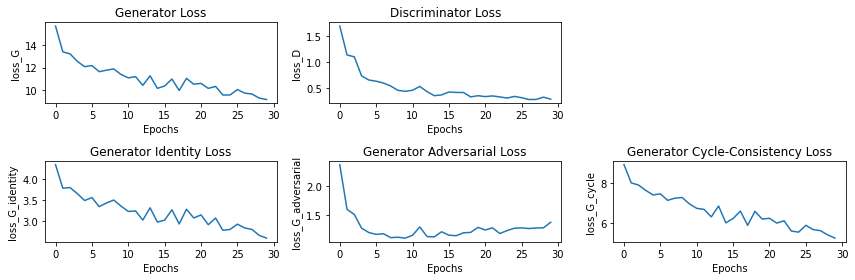

In [25]:
### 先にGoogle Driveをマウントしておくこと
# 損失関数の学習結果をプロット
plt.figure(figsize=(12, 4))

plt.subplot(231)
plt.plot(loss_dict['loss_G'])
plt.xlabel('Epochs')
plt.ylabel('loss_G')
plt.title('Generator Loss')

plt.subplot(232)
plt.plot(loss_dict['loss_D'])
plt.xlabel('Epochs')
plt.ylabel('loss_D')
plt.title('Discriminator Loss')

plt.subplot(234)
plt.plot(loss_dict['loss_G_identity'])
plt.xlabel('Epochs')
plt.ylabel('loss_G_identity')
plt.title('Generator Identity Loss')

plt.subplot(235)
plt.plot(loss_dict['loss_G_adversarial'])
plt.xlabel('Epochs')
plt.ylabel('loss_G_adversarial')
plt.title('Generator Adversarial Loss')

plt.subplot(236)
plt.plot(loss_dict['loss_G_cycle'])
plt.xlabel('Epochs')
plt.ylabel('loss_G_cycle')
plt.title('Generator Cycle-Consistency Loss')

plt.tight_layout()
plt.savefig('/content/drive/My Drive/loss_log.png')
plt.show()

In [22]:
# 最新のモデルの保存
torch.save(G_A2B.state_dict(), 'models/G_A2B_epoch{}.pth'.format(epoch+1))
torch.save(G_B2A.state_dict(), 'models/G_B2A_epoch{}.pth'.format(epoch+1))
torch.save(D_A.state_dict(), 'models/D_A_epoch{}.pth'.format(epoch+1))
torch.save(D_B.state_dict(), 'models/D_B_epoch{}.pth'.format(epoch+1))
print('saved!')

saved!


In [0]:
# モデルのダウンロード
!cp models/G_A2B_epoch30.pth /content/drive/My\ Drive/G_A2B_epoch30.pth
!cp models/G_B2A_epoch30.pth /content/drive/My\ Drive/G_B2A_epoch30.pth
!cp models/D_A_epoch30.pth /content/drive/My\ Drive/D_A_epoch30.pth
!cp models/D_B_epoch30.pth /content/drive/My\ Drive/D_B_epoch30.pth

from google.colab import files
files.download('models/G_A2B_epoch30.pth')
files.download('models/G_B2A_epoch30.pth')
files.download('models/D_A_epoch30.pth')
files.download('models/D_B_epoch30.pth')

In [19]:
# 重みのダウンロード
import pandas as pd
df = pd.DataFrame(loss_dict)
df.to_csv('models/loss_log.csv')
!cp models/loss_log.csv /content/drive/My\ Drive/loss_log.csv
files.download('models/loss_log.csv')
df.head()

,loss_G,loss_D,loss_G_identity,loss_G_adversarial,loss_G_cycle
0,"tensor(15.6388, grad_fn=<AddBackward0>)","tensor(1.6930, grad_fn=<AddBackward0>)","tensor(4.3559, grad_fn=<AddBackward0>)","tensor(2.3768, grad_fn=<AddBackward0>)","tensor(8.9060, grad_fn=<AddBackward0>)"
1,"tensor(13.3814, grad_fn=<AddBackward0>)","tensor(1.1353, grad_fn=<AddBackward0>)","tensor(3.7902, grad_fn=<AddBackward0>)","tensor(1.5957, grad_fn=<AddBackward0>)","tensor(7.9956, grad_fn=<AddBackward0>)"
2,"tensor(13.1988, grad_fn=<AddBackward0>)","tensor(1.0983, grad_fn=<AddBackward0>)","tensor(3.8047, grad_fn=<AddBackward0>)","tensor(1.5062, grad_fn=<AddBackward0>)","tensor(7.8879, grad_fn=<AddBackward0>)"
3,"tensor(12.5449, grad_fn=<AddBackward0>)","tensor(0.7297, grad_fn=<AddBackward0>)","tensor(3.6592, grad_fn=<AddBackward0>)","tensor(1.2672, grad_fn=<AddBackward0>)","tensor(7.6185, grad_fn=<AddBackward0>)"
4,"tensor(12.0780, grad_fn=<AddBackward0>)","tensor(0.6497, grad_fn=<AddBackward0>)","tensor(3.4936, grad_fn=<AddBackward0>)","tensor(1.1901, grad_fn=<AddBackward0>)","tensor(7.3942, grad_fn=<AddBackward0>)"


## 評価

In [0]:
# データセットのパスを取得
test_img_A, test_img_B = dl.make_datapath_list(is_train=False)

# Datasetを作成
mean = (0.5,)
std = (0.5,)
test_dataset = dl.UnpairedDataset(test_img_A, test_img_B,
                                  transform=dl.ImageTransform(mean, std))

# DataLoaderを作成
test_dataloader = data.DataLoader(test_dataset,
                                   batch_size=1,
                                   shuffle=True)

In [81]:
batch = iter(test_dataloader).next()
print(batch['A'].shape)
print(batch['B'].shape)
print(batch['path_A'])
print(batch['path_B'])

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
['dataset/apple2orange/testA/n07740461_7471.jpg']
['dataset/apple2orange/testB/n07749192_4141.jpg']


### A2B

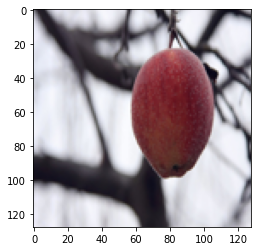

In [82]:
dl.imshow(batch['A'])

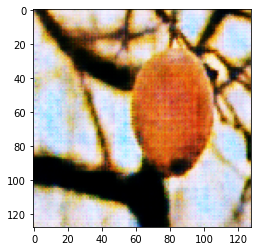

In [83]:
fake_B = G_A2B(batch['A'])

img = fake_B.squeeze()          # batchの次元を潰す
img_np = img.detach().numpy()         # NumPy配列に変換
img_np = 0.5 * (img_np + 1)  # 正規化を元に戻す，[-1, 1] -> [0, 1]
plt.imshow(np.transpose(img_np, (1, 2, 0)))  # [c, h, w] -> [h, w, c]

### B2A

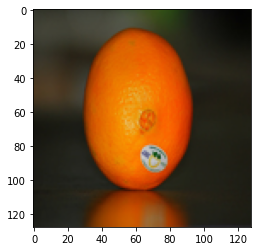

In [76]:
dl.imshow(batch['B'])

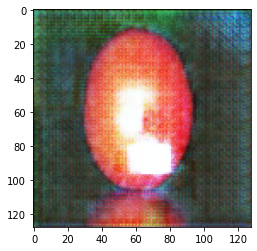

In [77]:
fake_A = G_B2A(batch['B'])

img = fake_A.squeeze()          # batchの次元を潰す
img_np = img.detach().numpy()         # NumPy配列に変換
img_np = 0.5 * (img_np + 1)  # 正規化を元に戻す，[-1, 1] -> [0, 1]
plt.imshow(np.transpose(img_np, (1, 2, 0)))  # [c, h, w] -> [h, w, c]